In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
    import seaborn as sns

    import mbuild as mb
    import metamds as mds
    import mdtraj as md
    from mdtraj.html import TrajectorySliderView

%matplotlib inline
!rm -rf output/ *.top *.gro

In [3]:
def build_ethane_box(box, n_molecules, **kwargs):
    from mbuild.examples import Ethane
    ethane = Ethane()
    full_box = mb.fill_box(ethane, n_molecules, box)
    full_box.name = '{}_ethanes'.format(n_molecules)
    return full_box

In [4]:
# Input parameters
parameters = {'n_molecules': 200,
              'box': [3, 3, 3],
              'forcefield': 'OPLS-aa'}

# Build the initial configuration
compound = build_ethane_box(**parameters)
#compound.visualize()

parameters['compound'] = compound

In [5]:
def create_run_script(compound, forcefield, input_dir, **kwargs):
    name = compound.name
    em = os.path.join(input_dir, 'em.mdp')
    nvt = os.path.join(input_dir, 'nvt.mdp')
    gro = '{name}.gro'.format(name=name)
    top = '{name}.top'.format(name=name)

    compound.save(top, forcefield=forcefield, overwrite=True)

    em_grompp = 'gmx grompp -f {mdp} -c {gro} -p {top} -o em.tpr'.format(mdp=em, gro=gro, top=top)
    em_mdrun = 'gmx mdrun -v -deffnm em'

    nvt_grompp = 'gmx grompp -f {mdp} -c em.gro -p {top} -o nvt.tpr'.format(mdp=nvt, top=top)
    nvt_mdrun = 'gmx mdrun -v -deffnm nvt'

    script = (em_grompp, em_mdrun, nvt_grompp, nvt_mdrun)
    return script

In [6]:
# Initialize a simulation instance with a template and some metadata
sim = mds.Simulation(name='ethane', template=create_run_script, output_dir='output')

# Parameterize our simulation template
task = sim.parametrize(**parameters)

In [7]:
# Run
task.execute(hostname='rahman.vuse.vanderbilt.edu', username='ctk3b')

DEBUG:ethane_debug:rsync -r -h --progress /Users/ctk3b/science/python/imodels/demos/demos/ethane_box/binary_lj_sim /Users/ctk3b/science/python/imodels/demos/demos/ethane_box/em.mdp /Users/ctk3b/science/python/imodels/demos/demos/ethane_box/nvt.mdp ctk3b@rahman.vuse.vanderbilt.edu:/raid6/homes/ctk3b/tmp.2VtjTzjJHl
DEBUG:ethane_debug:b'building file list ... '
DEBUG:ethane_debug:b' 0 files...'
DEBUG:ethane_debug:b'12 files to consider'
DEBUG:ethane_debug:b'em.mdp'
DEBUG:ethane_debug:b'         853 100%    0.00kB/s    0:00:00'
DEBUG:ethane_debug:b'         853 100%    0.00kB/s    0:00:00 (xfer#1, to-check=11/12)'
DEBUG:ethane_debug:b'nvt.mdp'
DEBUG:ethane_debug:b'         533 100%  520.51kB/s    0:00:00'
DEBUG:ethane_debug:b'         533 100%  520.51kB/s    0:00:00 (xfer#2, to-check=10/12)'
DEBUG:ethane_debug:b'binary_lj_sim/'
DEBUG:ethane_debug:b'binary_lj_sim/binary_lj_sim.jinja'
DEBUG:ethane_debug:b'       2.02K 100%    1.93MB/s    0:00:00'
DEBUG:ethane_debug:b'       2.02K 100%    1.9

In [8]:
task.status()['start_time']

'Thu Jan 28 09:43:52 2016'

In [12]:
task.sync()

DEBUG:ethane_debug:rsync -r -h --progress ctk3b@rahman.vuse.vanderbilt.edu:/raid6/homes/ctk3b/tmp.2VtjTzjJHl/output/task_0/* /Users/ctk3b/science/python/imodels/demos/demos/ethane_box/output/task_0
DEBUG:ethane_debug:b'receiving file list ... '
DEBUG:ethane_debug:b'17 files to consider'
DEBUG:ethane_debug:b'skipping non-regular file "binary_lj_sim"'
DEBUG:ethane_debug:b'skipping non-regular file "em.mdp"'
DEBUG:ethane_debug:b'#mdout.mdp.1#'
DEBUG:ethane_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:ethane_debug:b'      11.63K 100%   11.09MB/s    0:00:00 (xfer#1, to-check=16/17)'
DEBUG:ethane_debug:b'skipping non-regular file "nvt.mdp"'
DEBUG:ethane_debug:b'200_ethanes.gro'
DEBUG:ethane_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:ethane_debug:b'      72.08K 100%    7.64MB/s    0:00:00 (xfer#2, to-check=15/17)'
DEBUG:ethane_debug:b'200_ethanes.top'
DEBUG:ethane_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:ethane_debug:b'       4.40K 100%  429.39kB/s    0:

In [13]:
# Analyze
trajectories = task.get_output_files('trajectories')
topologies = task.get_output_files('topologies')

trajectories

['/Users/ctk3b/science/python/imodels/demos/demos/ethane_box/output/task_0/em.trr',
 '/Users/ctk3b/science/python/imodels/demos/demos/ethane_box/output/task_0/nvt.trr',
 '/Users/ctk3b/science/python/imodels/demos/demos/ethane_box/output/task_0/nvt.xtc']

In [14]:
traj = md.load('output/task_0/nvt.xtc', top='output/task_0/em.gro')
print(traj)
# TrajectorySliderView(traj)

<mdtraj.Trajectory with 49 frames, 1600 atoms, 200 residues, and unitcells>


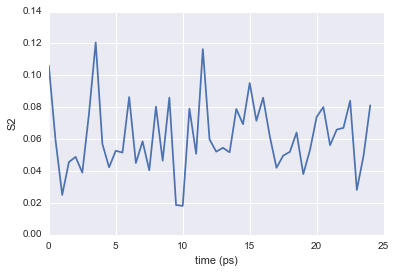

In [15]:
s2 = md.compute_nematic_order(traj, 'residues')
plt.plot(traj.time, s2)
plt.xlabel('time (ps)')
plt.ylabel('S2')

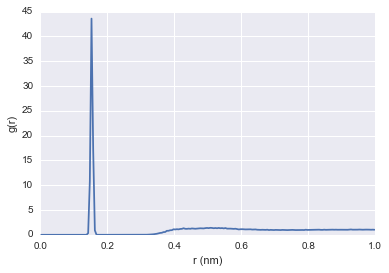

In [16]:
pairs = traj.top.select_pairs('name C', 'name C')
r, g_r = md.compute_rdf(traj, pairs)
plt.plot(r, g_r)
plt.xlabel('r (nm)')
plt.ylabel('g(r)')

In [ ]:
os.getcwd()